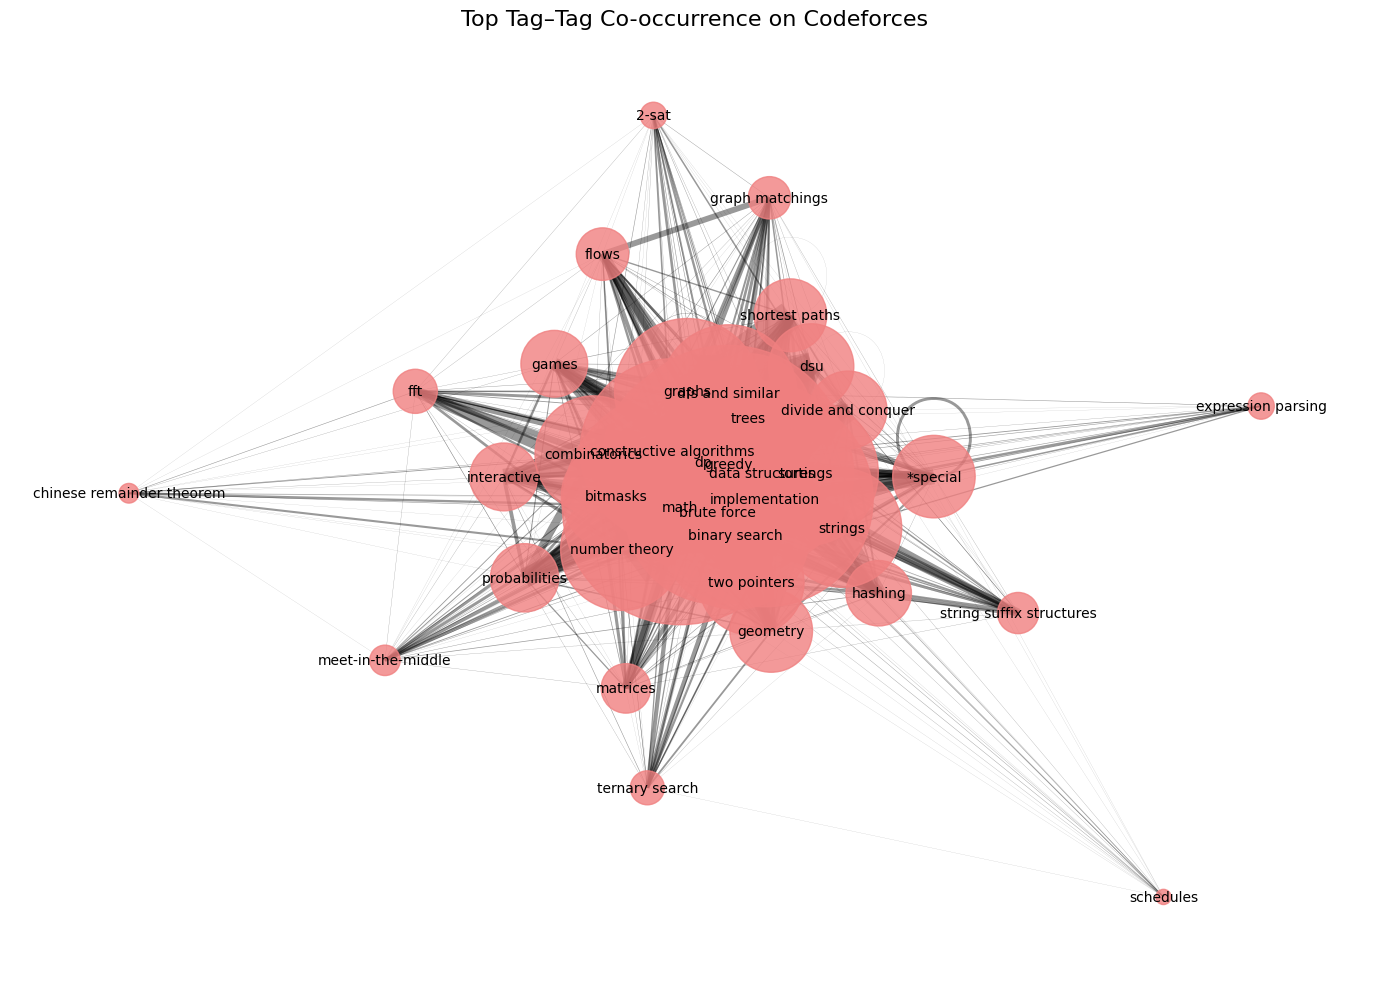

In [22]:
import requests
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

# Step 1: Fetch Codeforces problems
def fetch_problemset():
    url = "https://codeforces.com/api/problemset.problems"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data["result"]["problems"]
    except requests.exceptions.RequestException as e:
        print("Failed to fetch problemset:", e)
        return []

# Step 2: Build Tag–Tag Graph
def build_tag_graph(problems):
    G = nx.Graph()
    tag_counts = {}

    for prob in problems:
        tags = prob.get("tags", [])
        if len(tags) < 2:
            continue
        for tag in tags:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1

        for t1, t2 in combinations(tags, 2):
            if G.has_edge(t1, t2):
                G[t1][t2]["weight"] += 1
            else:
                G.add_edge(t1, t2, weight=1)

    for tag, count in tag_counts.items():
        G.add_node(tag, count=count)

    return G

# Step 3: Visualize Top Tag-Tag Graph
def visualize_tag_graph(G, top_n=50):
    # Get top N tags by frequency
    top_tags = sorted(G.nodes(data=True), key=lambda x: x[1]['count'], reverse=True)[:top_n]
    selected_tags = {tag for tag, _ in top_tags}
    H = G.subgraph(selected_tags).copy()

    # Set up layout
    pos = nx.spring_layout(H, seed=42)
    node_sizes = [H.nodes[node]['count'] * 10 for node in H.nodes()]
    edge_weights = [H[u][v]['weight'] for u, v in H.edges()]

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
    nx.draw_networkx_edges(H, pos, width=[w * 0.1 for w in edge_weights], alpha=0.4)
    nx.draw_networkx_labels(H, pos, font_size=10)
    plt.title("Top Tag–Tag Co-occurrence on Codeforces", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Execute
problems = fetch_problemset()
if problems:
    tag_graph = build_tag_graph(problems)
    visualize_tag_graph(tag_graph, top_n=50)


In [37]:
if problems:
    tag_graph = build_tag_graph(problems)

    num_nodes = tag_graph.number_of_nodes()
    num_edges = tag_graph.number_of_edges()
    max_possible_edges = num_nodes * (num_nodes - 1) // 2
    density = num_edges / max_possible_edges

    print(f"Tag Graph Metrics:")
    print(f"- Nodes (Tags): {num_nodes}")
    print(f"- Edges (Co-occurrences): {num_edges}")
    print(f"- Max Possible Edges: {max_possible_edges}")
    print(f"- Density: {density:.3f} ({(density*100):.1f}% of possible connections exist)")

    # Degree analysis
    degrees = dict(tag_graph.degree())
    avg_degree = sum(degrees.values()) / num_nodes
    max_degree = max(degrees.values())
    min_degree = min(degrees.values())

    print("\nTag Connectivity:")
    print(f"- Average connections per tag: {avg_degree:.1f}")
    print(f"- Most connected tag: {max_degree} co-occurrences")
    print(f"- Least connected tag: {min_degree} co-occurrences")


Tag Graph Metrics:
- Nodes (Tags): 37
- Edges (Co-occurrences): 604
- Max Possible Edges: 666
- Density: 0.907 (90.7% of possible connections exist)

Tag Connectivity:
- Average connections per tag: 32.6
- Most connected tag: 38 co-occurrences
- Least connected tag: 17 co-occurrences


In [23]:
!pip install -q python-louvain


Detected 3 communities.


<ipython-input-28-e42b722aa9ab>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)


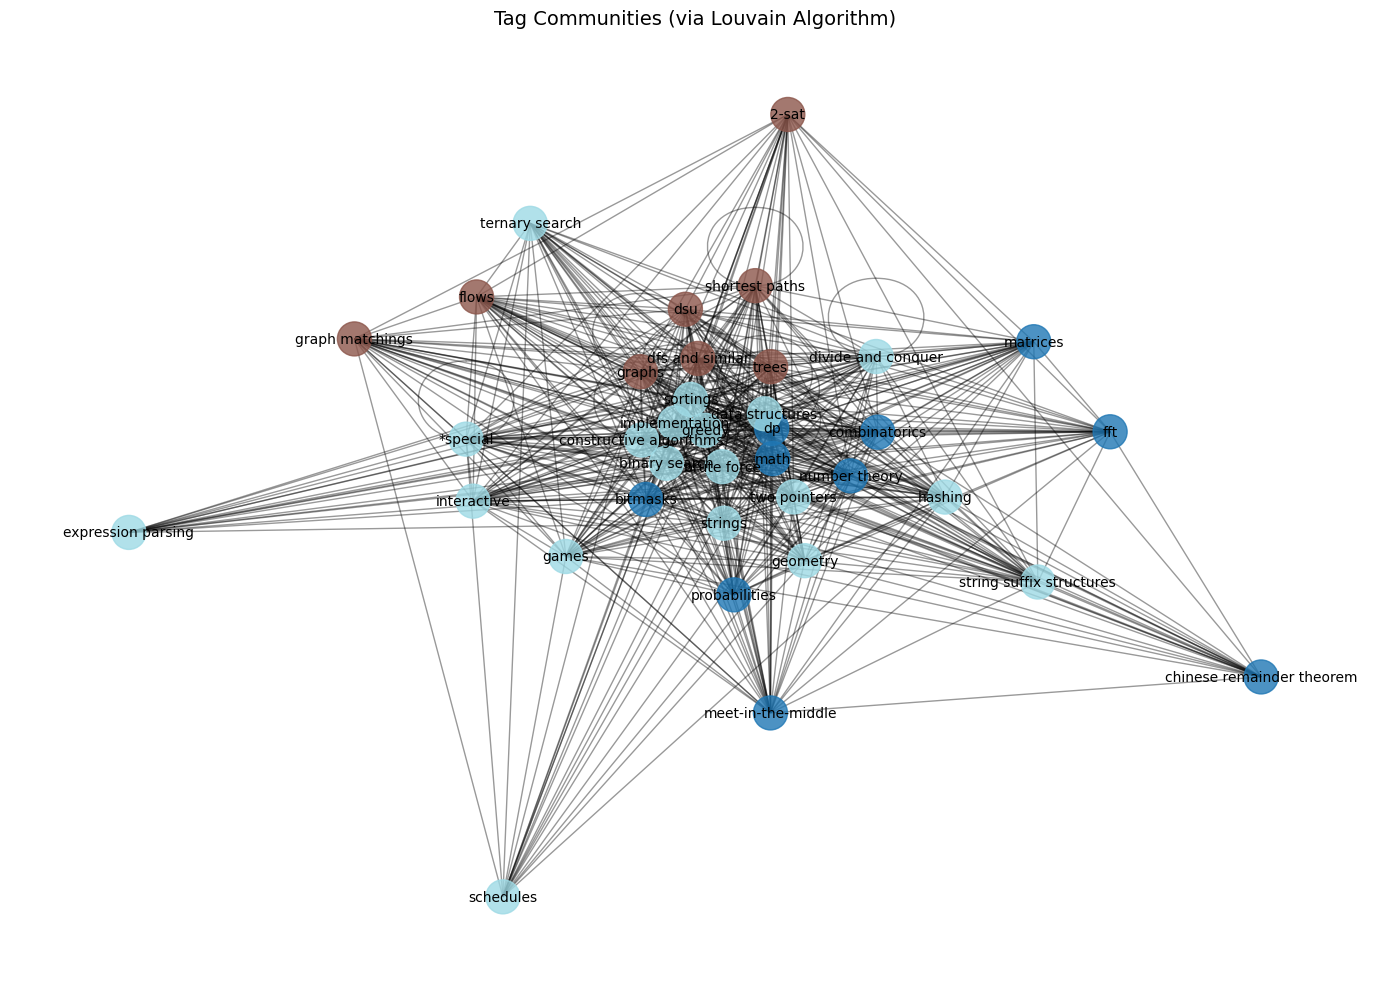

In [28]:
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain


# Step 1: Apply Louvain community detection
partition = community_louvain.best_partition(tag_graph, weight='weight')
print(f"Detected {len(set(partition.values()))} communities.")

# Step 2: Visualize the tag graph with community coloring
def visualize_tag_communities(graph, partition):
    pos = nx.spring_layout(graph, seed=42, k=0.3)
    cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(graph, pos,
                           node_size=600,
                           node_color=[partition[n] for n in graph.nodes()],
                           cmap=cmap, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=10)

    plt.title("Tag Communities (via Louvain Algorithm)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_tag_communities(tag_graph, partition)


In [29]:
from collections import defaultdict

communities = defaultdict(list)
for tag, com_id in partition.items():
    communities[com_id].append(tag)

# Display each community
for com_id, tags in communities.items():
    print(f"\nCommunity {com_id} ({len(tags)} tags):")
    print(", ".join(tags))



Community 2 (19 tags):
binary search, divide and conquer, implementation, interactive, greedy, two pointers, sortings, constructive algorithms, brute force, data structures, *special, expression parsing, geometry, games, string suffix structures, strings, hashing, ternary search, schedules

Community 1 (8 tags):
dfs and similar, trees, dsu, graphs, shortest paths, flows, graph matchings, 2-sat

Community 0 (10 tags):
dp, math, bitmasks, combinatorics, fft, number theory, probabilities, matrices, chinese remainder theorem, meet-in-the-middle


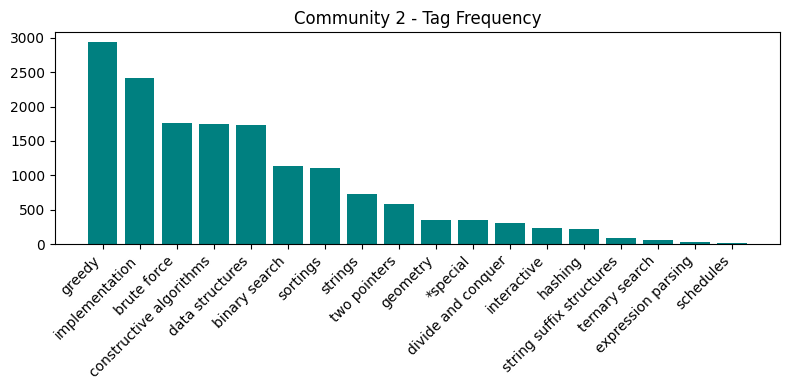

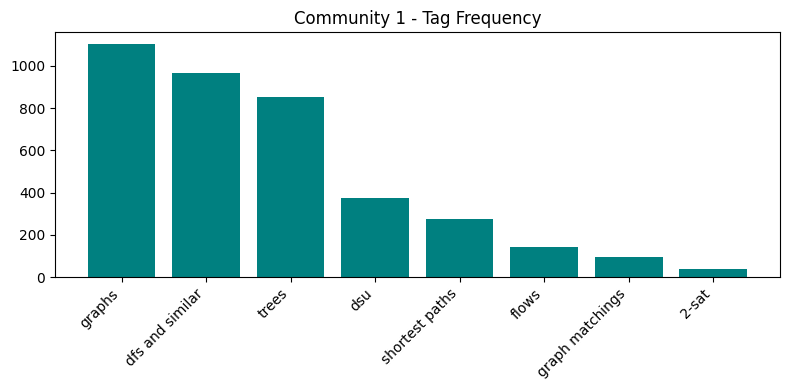

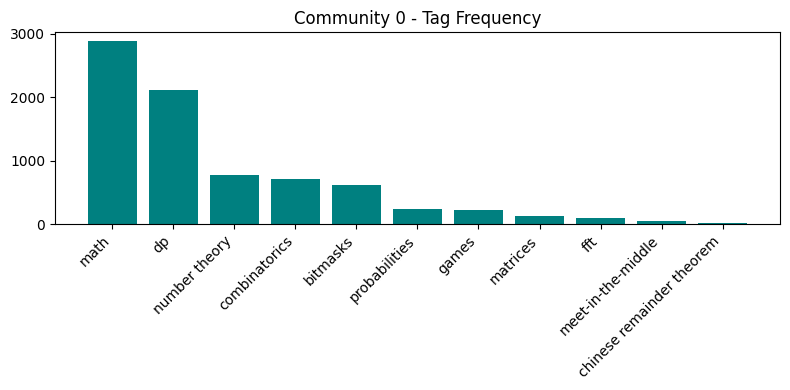

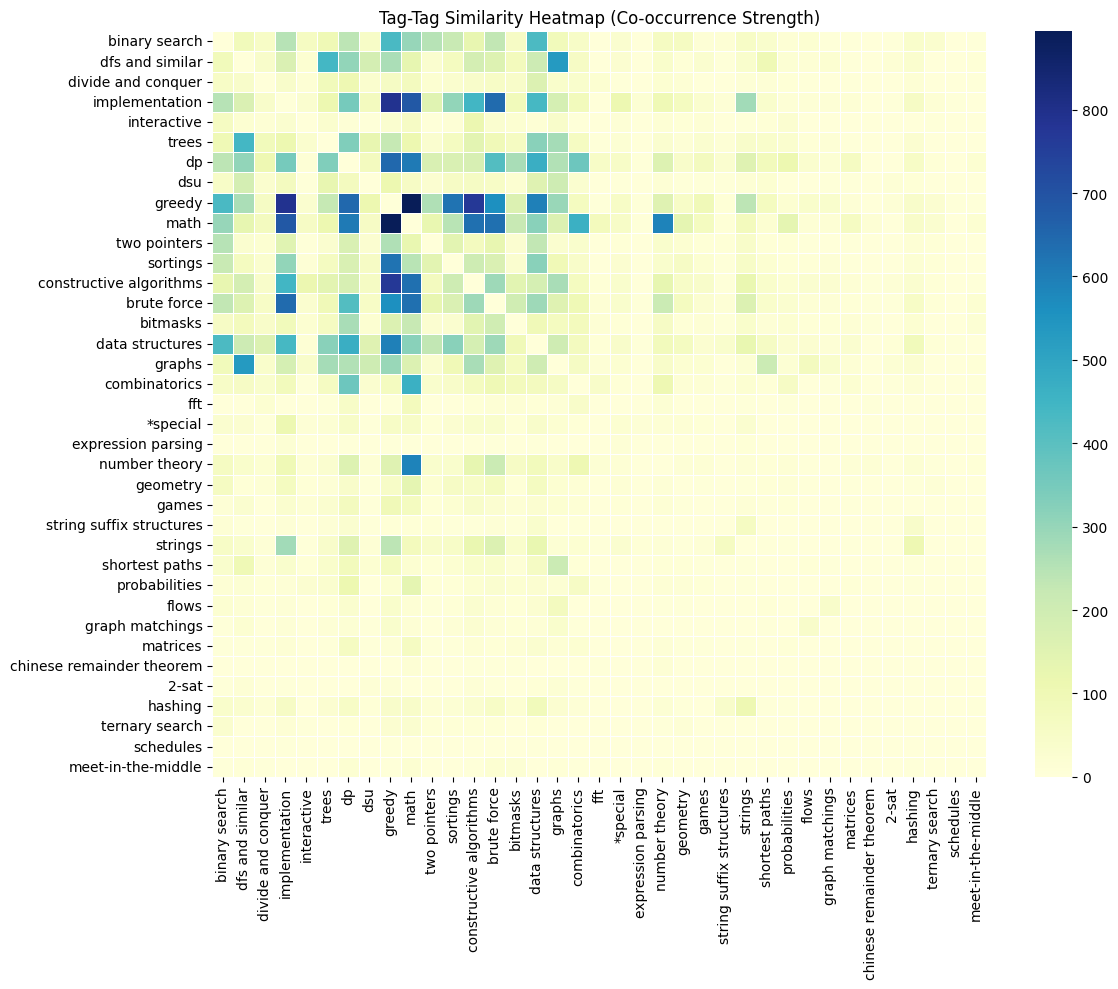

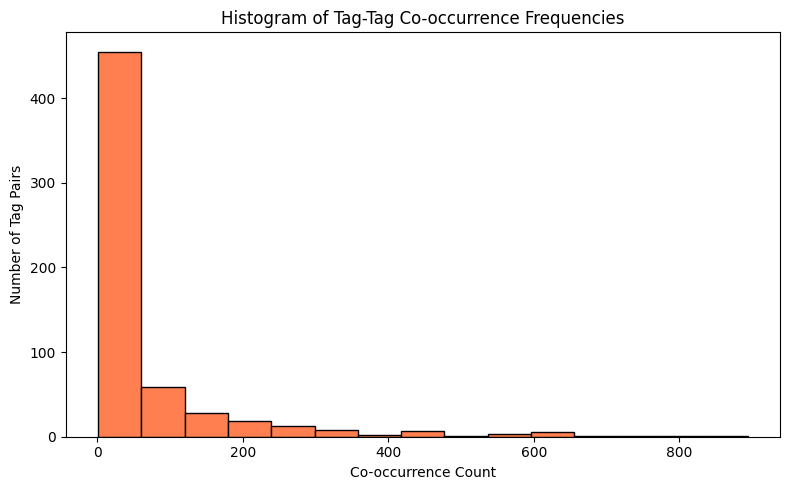

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import numpy as np

# 1. Community-wise Tag Frequency Distribution
def plot_community_tag_frequency(graph, partition):
    community_freq = defaultdict(list)
    for node, com_id in partition.items():
        freq = graph.nodes[node].get("count", 0)
        community_freq[com_id].append((node, freq))

    for com_id, tag_freqs in community_freq.items():
        tags, freqs = zip(*sorted(tag_freqs, key=lambda x: x[1], reverse=True))
        plt.figure(figsize=(8, 4))
        plt.bar(tags, freqs, color="teal")
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Community {com_id} - Tag Frequency")
        plt.tight_layout()
        plt.show()

# 2. Tag Similarity Matrix (Heatmap)
def plot_tag_similarity_heatmap(graph):
    tags = list(graph.nodes())
    matrix = np.zeros((len(tags), len(tags)))
    tag_index = {tag: i for i, tag in enumerate(tags)}

    for u, v, data in graph.edges(data=True):
        i, j = tag_index[u], tag_index[v]
        weight = data.get("weight", 0)
        matrix[i][j] = weight
        matrix[j][i] = weight  # Since undirected

    df = pd.DataFrame(matrix, index=tags, columns=tags)
    plt.figure(figsize=(12, 10))
    sns.heatmap(df, cmap="YlGnBu", linewidths=0.5)
    plt.title("Tag-Tag Similarity Heatmap (Co-occurrence Strength)")
    plt.tight_layout()
    plt.show()

# 3. Tag-Tag Co-occurrence Histogram
def plot_tag_tag_histogram(graph):
    weights = [d["weight"] for _, _, d in graph.edges(data=True)]
    plt.figure(figsize=(8, 5))
    plt.hist(weights, bins=15, color="coral", edgecolor="black")
    plt.title("Histogram of Tag-Tag Co-occurrence Frequencies")
    plt.xlabel("Co-occurrence Count")
    plt.ylabel("Number of Tag Pairs")
    plt.tight_layout()
    plt.show()

# Call the functions
plot_community_tag_frequency(tag_graph, partition)
plot_tag_similarity_heatmap(tag_graph)
plot_tag_tag_histogram(tag_graph)
